<a href="https://colab.research.google.com/github/FahmidaAkterShimu/Final-Project-using-NLP/blob/main/Hate_Speech_Detection_using_LSTM.ipynb5" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
# 1. Importing libraries
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from imblearn.over_sampling import SMOTE

In [95]:
# 2. Load dataset
df = pd.read_csv('/content/Dataset.csv')
df = df[['label', 'text']]  # Only keep relevant columns
df.rename(columns={'label': 'class', 'text': 'tweet'}, inplace=True)

In [104]:
df.shape

(40623, 4)

In [ ]:
df.head()

In [96]:
print(df.columns)

Index(['class', 'tweet'], dtype='object')


In [97]:
print(df['class'].unique())

['hate' 'nothate']


In [98]:
# 3. Map labels to binary values
# Convert label to lowercase and map
df['class'] = df['class'].astype(str)
df['class'] = df['class'].str.lower().map({'hate': 1, 'nothate': 0})
df.dropna(subset=['class'], inplace=True)
df['class'] = df['class'].astype(int)

# Check label counts
print(df['class'].value_counts())


class
1    22124
0    18499
Name: count, dtype: int64


In [99]:
# 4. Clean the text
df['processed_tweet'] = df['tweet'].str.replace(r'[^a-zA-Z]', ' ', regex=True)
df['processed_tweet_2'] = df['processed_tweet'].str.replace(r'[\s]+', ' ', regex=True)
df.drop(columns=['tweet', 'processed_tweet'], inplace=True)

In [100]:
# 5. Load spaCy model
nlp = spacy.load('en_core_web_sm')

def lemmatization(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])

In [101]:
# 6. Preprocessing
df['lemma_tweet'] = df['processed_tweet_2'].apply(lemmatization)
df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)
df['final_tweet'] = df['final_tweet'].str.lower()

In [102]:
# 7. One-hot and Padding
vocab_size = 10000
sentence_length = 20
one_hot_representation = [one_hot(tweet, vocab_size) for tweet in df['final_tweet']]
embedded_tweet = pad_sequences(one_hot_representation, padding='pre', maxlen=sentence_length)

In [103]:
# 8. Feature and Label
X = np.array(embedded_tweet)
y = np.array(df['class'])

In [105]:
# 9. SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [106]:
# 10. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
# 11. Model architecture (Binary classification)
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [108]:
# 12. Train model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

M = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=[early_stop, model_checkpoint])

Epoch 1/30
885/885 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step - accuracy: 0.5848 - loss: 0.6574 - val_accuracy: 0.7355 - val_loss: 0.5279
Epoch 2/30
885/885 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.7712 - loss: 0.4826 - val_accuracy: 0.7479 - val_loss: 0.5099
Epoch 3/30
885/885 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8152 - loss: 0.3994 - val_accuracy: 0.7517 - val_loss: 0.5200
Epoch 4/30
885/885 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.8508 - loss: 0.3338 - val_accuracy: 0.7470 - val_loss: 0.5654
Epoch 5/30
885/885 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.8697 - loss: 0.2872 - val_accuracy: 0.7353 - val_loss: 0.6554


In [109]:
# 13. Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7368 - loss: 0.5209
Model Accuracy: 74.16%


In [110]:
# 14. Prediction & Evaluation
pred_prob = model.predict(X_test)
pred = (pred_prob > 0.5).astype(int)
print(classification_report(y_test, pred))

277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
              precision    recall  f1-score   support

           0       0.77      0.68      0.73      4421
           1       0.72      0.80      0.76      4429

    accuracy                           0.74      8850
   macro avg       0.74      0.74      0.74      8850
weighted avg       0.74      0.74      0.74      8850



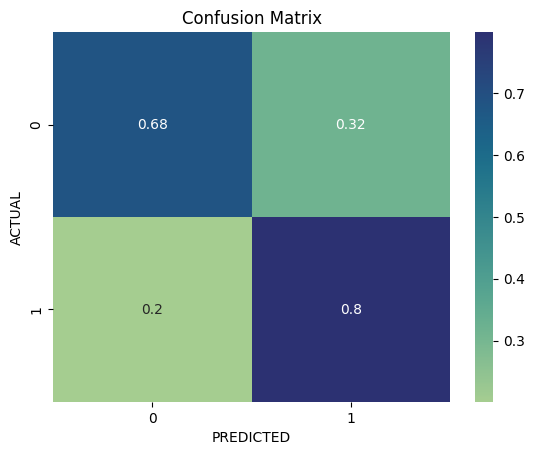

In [111]:
# 15. Confusion Matrix
cf = confusion_matrix(y_test, pred, normalize='true')
sns.heatmap(cf, annot=True, cmap='crest')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('Confusion Matrix')
plt.show()

In [112]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([ch if ch.isalpha() else ' ' for ch in text])
    text = ' '.join(text.split())
    text = lemmatization(text)
    text = remove_stopwords(text)
    encoded = one_hot(text, vocab_size)
    padded = pad_sequences([encoded], maxlen=sentence_length, padding='pre')
    return padded

def predict_hate_speech(text):
    padded = preprocess_text(text)
    prediction = model.predict(padded)[0][0]
    return "Hate Speech" if prediction >= 0.5 else "Normal Text"

In [115]:
# Check the model
user_input = input("Enter a sentence to check for hate speech: ")
result = predict_hate_speech(user_input)
print("Prediction:", result)

Enter a sentence to check for hate speech: i will kill you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction: Normal Text
